<a href="https://colab.research.google.com/github/ashu-vpu/DSIP_Project_AQI_Prediction/blob/main/Code/Data_Science_IP_Project_PyTorch_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount drive to work from Google drive and Colab

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Create symbolic links to the area where the datasets are present to work with

In [5]:
!mkdir -p /content/data
!rm -rf /content/data/*.csv
!ln -s /content/drive/MyDrive/DE_Scale_Project/Datasets/All_cities/*.csv /content/data/

Read the dataset, i.e. ALL cities Pollutant data csv file

In [12]:
#Imports
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt



In [7]:
def read_csv(path_to_file):
  return pd.read_csv(path_to_file)

df_All_cities_2019_2022 = read_csv('/content/data/df_All_cities_2019_2022_processed.csv')
df_All_cities_2023 = read_csv('/content/data/df_All_cities_2023.csv')

In [8]:
# install PyTorch
!pip install torch

In [9]:
# Convert pandas DataFrame to PyTorch Dataset
class PandasTorchDataset(Dataset):
    def __init__(self, df, feature_cols, label_col):
        self.features = df[feature_cols].values  # Extract features as a numpy array
        self.labels = df[label_col].values      # Extract labels as a numpy array

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        features = self.features[idx]
        label = self.labels[idx]
        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

In [10]:


# Prepare train and test DataFrames
train_df = df_All_cities_2019_2022
test_df = df_All_cities_2023

# Ensure 'Timestamp' is a datetime object and sort data
train_df['Timestamp'] = pd.to_datetime(train_df['Timestamp'])
train_df = train_df.sort_values(by=['City', 'Timestamp'])

test_df['Timestamp'] = pd.to_datetime(test_df['Timestamp'])
test_df = test_df.sort_values(by=['City', 'Timestamp'])

# Create lag features for the past 24 hours
for lag_val in range(1, 25):
    train_df[f"lag_{lag_val}"] = train_df.groupby("City")["AQI"].shift(lag_val)
    test_df[f"lag_{lag_val}"] = test_df.groupby("City")["AQI"].shift(lag_val)

# Drop rows with NaN values introduced by the lagging
train_df = train_df.dropna()
test_df = test_df.dropna()

# Define features and label
feature_cols = [f"lag_{i}" for i in range(1, 25)] + ['PM2p5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'Ozone']
label_col = "AQI"


# Create Dataset
train_dataset = PandasTorchDataset(train_df, feature_cols, label_col)
test_dataset = PandasTorchDataset(test_df, feature_cols, label_col)


In [13]:
# Define LSTM Model

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x.unsqueeze(1), (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Model Parameters
input_size = len(feature_cols)
hidden_size = 64
num_layers = 2
output_size = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [14]:
# Train the Model

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training Loop
epochs = 30
model.train()
for epoch in range(epochs):
    total_loss = 0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}")


Epoch 1/30, Loss: 10625.414660740953
Epoch 2/30, Loss: 3878.077580032228
Epoch 3/30, Loss: 1209.8883373121892
Epoch 4/30, Loss: 794.3448486810236
Epoch 5/30, Loss: 450.9142094267111
Epoch 6/30, Loss: 482.2619760859822
Epoch 7/30, Loss: 410.97796874566103
Epoch 8/30, Loss: 315.87909740249125
Epoch 9/30, Loss: 250.48330542457424
Epoch 10/30, Loss: 222.67244862741768
Epoch 11/30, Loss: 200.4631505688973
Epoch 12/30, Loss: 221.3057286158557
Epoch 13/30, Loss: 167.94331967653633
Epoch 14/30, Loss: 678.9618078964016
Epoch 15/30, Loss: 415.00402545296186
Epoch 16/30, Loss: 517.4017191400272
Epoch 17/30, Loss: 441.24251459673116
Epoch 18/30, Loss: 484.0085245454857
Epoch 19/30, Loss: 446.5891084282319
Epoch 20/30, Loss: 417.88010322185113
Epoch 21/30, Loss: 3395.966229995318
Epoch 22/30, Loss: 756.0463821579872
Epoch 23/30, Loss: 712.0503845600532
Epoch 24/30, Loss: 482.48105710889865
Epoch 25/30, Loss: 437.30644802437007
Epoch 26/30, Loss: 413.0097323991676
Epoch 27/30, Loss: 345.163134988601

In [15]:
# FOrecast AQI for year 2023

# Test DataLoader

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Forecast
model.eval()
forecasted_values = []
with torch.no_grad():
    for features, _ in test_loader:
        features = features.to(device)  # Send to the appropriate device (CPU/GPU)
        prediction = model(features).item()  # Get the prediction as a scalar
        forecasted_values.append(prediction)

# Convert forecasted values to a DataFrame for further analysis
test_df['Forecasted_AQI'] = forecasted_values


Mean Absolute Error (MAE): 14.342140058794408
Root Mean Square Error (RMSE): 18.66457416343134


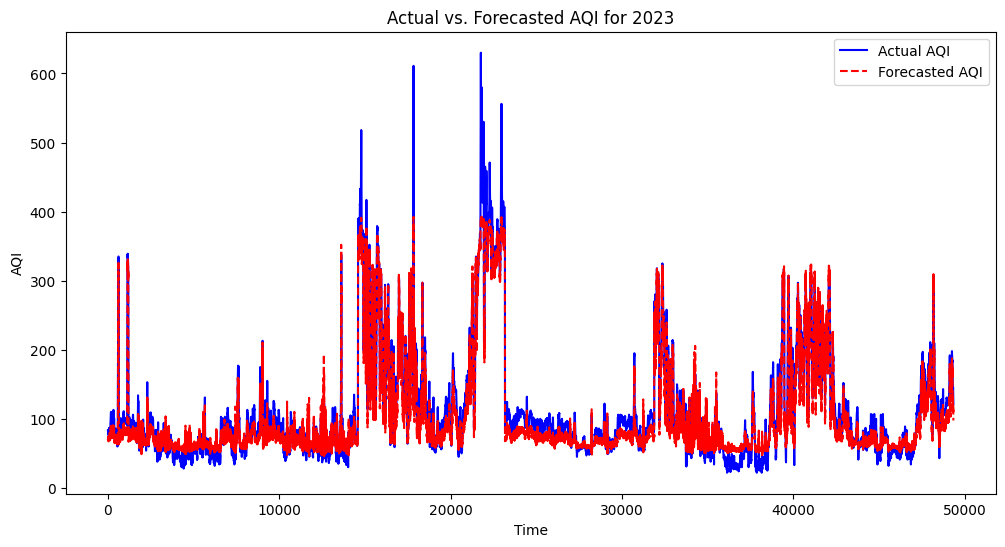

In [16]:
# Evaluate forecast accuracy and plot the forecasted and actual values



# Actual AQI values from 2023
actual_values = [row[1].item() for row in test_dataset]

# Calculate MAE and RMSE
mae = np.mean(np.abs(np.array(forecasted_values) - np.array(actual_values)))
rmse = np.sqrt(np.mean((np.array(forecasted_values) - np.array(actual_values))**2))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Square Error (RMSE): {rmse}")

plt.figure(figsize=(12, 6))
plt.plot(actual_values, label="Actual AQI", color="blue")
plt.plot(forecasted_values, label="Forecasted AQI", color="red", linestyle="dashed")
plt.legend()
plt.title("Actual vs. Forecasted AQI for 2023")
plt.xlabel("Time")
plt.ylabel("AQI")
plt.show()
